UMPM


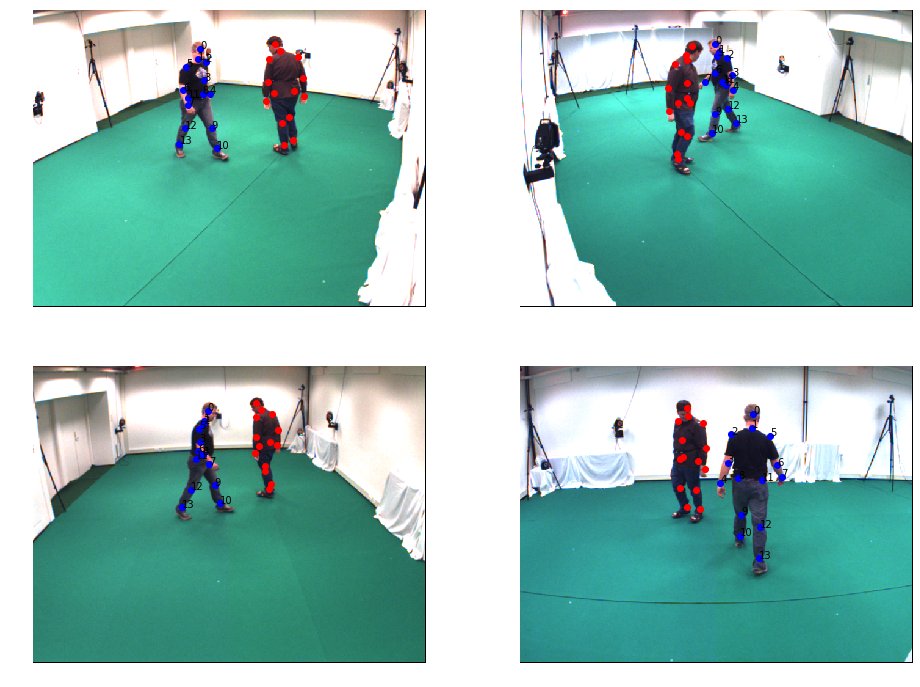

In [17]:
%matplotlib inline
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
sys.path.insert(0, './')
from mvpose.data import umpm
from os.path import join
import numpy as np
from time import time
from openpose import OpenPose

pe = OpenPose(tmp=Settings['tmp'])

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
video = 'p2_free_1'
#FRAME = 0

X, Y, Calib = umpm.get(root, video, user, pwd)
Imgs = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

gt1 = Y[FRAME, 0:14, 0:3].astype('float64')
gt2 = Y[FRAME, 14:, 0:3].astype('float64')

Per1_2d = []
Per1_3d = []

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    gt1_2d = cam.projectPoints(gt1)
    Per1_2d.append(gt1_2d[2:])
    Per1_3d.append(gt1[2:])
    gt2_2d = cam.projectPoints(gt2)
    ax.scatter(gt1_2d[:, 0], gt1_2d[:, 1], color='blue')
    ax.scatter(gt2_2d[:, 0], gt2_2d[:, 1], color='red')
    
    for jid, (x, y) in enumerate(gt1_2d):
        ax.text(x, y, str(jid))
    
plt.show()

extract pose with openpose
	elapsed 0.0013077259063720703


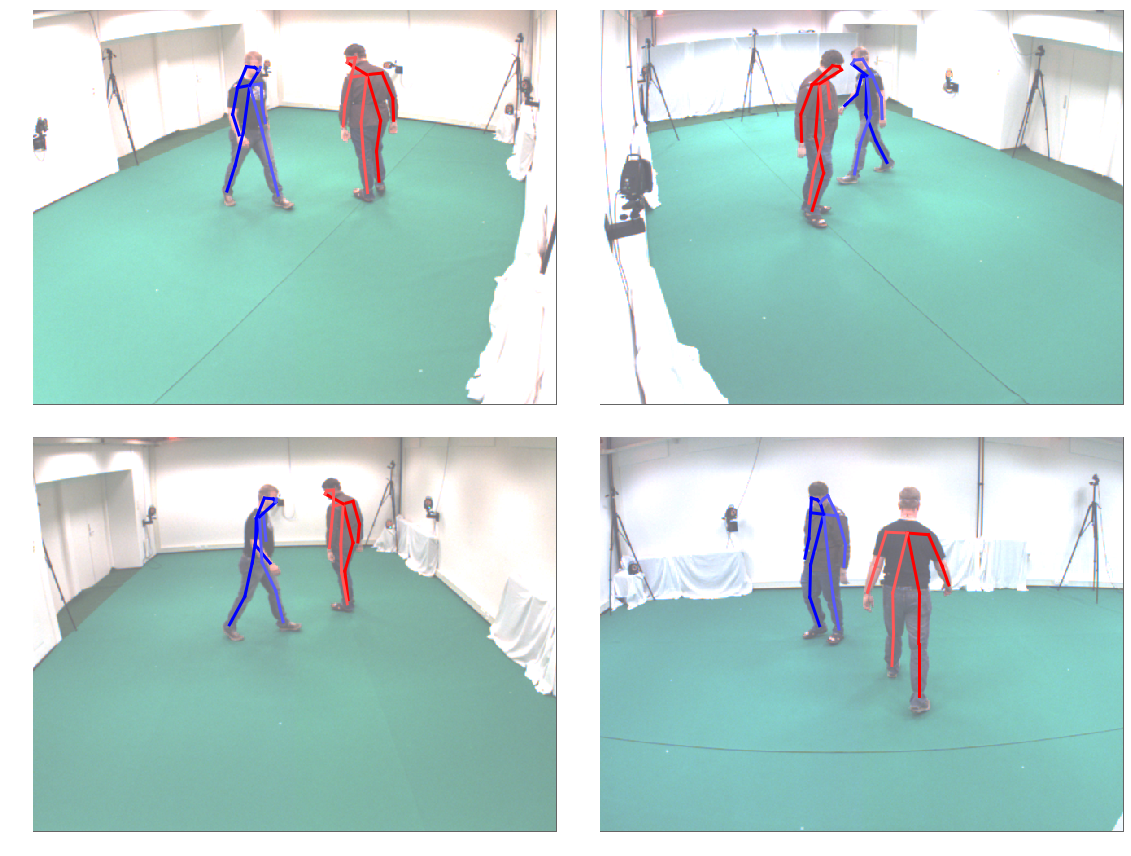

In [23]:
import mvpose.baseline.baseline as bl

print('extract pose with openpose')
_start = time()
positions = pe.predict(Imgs, 'umpm_' + video, FRAME)
_end = time()
print('\telapsed', _end - _start)

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

# Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Imgs[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, person in enumerate(positions[idx]):
        draw_mscoco_human2d(ax, person[:, 0:2], 
                            color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [27]:
positions3d = bl.estimate(Calib, positions)

len(R)

2

In [2]:
Per1_2d = np.array(Per1_2d)
Per1_2d = np.pad(Per1_2d, [(0, 0), (0, 0), (0, 1)], 'constant', constant_values=1)
print('2d', Per1_2d.shape)

Per1_3d = np.array(Per1_3d)
print('3d', Per1_3d.shape)

2d (4, 12, 3)
3d (4, 12, 3)


In [3]:
from mvpose.data.base_poses import BasePoses
base_poses = BasePoses('../data/base_poses.txt')

L = base_poses.umpm(gt1)
for lid, s in enumerate(L):
    print((lid, s))

(0, 317.02554)
(1, 200.77211)
(2, 322.17545)
(3, 200.2671)
(4, 436.71298)
(5, 467.09518)
(6, 440.74475)
(7, 469.97607)
(8, 200.57106)
(9, 423.7941)
(10, 556.039)
(11, 541.2377)


In [4]:
X = np.ones((4, 1), np.float32)

Ps = np.array([cam.P.flatten() for cam in Calib])
Per1_2d = Per1_2d.reshape((4, -1))
Per1_3d = Per1_3d.reshape((4, -1))
L_ = np.array([L, L, L, L])
Y = np.concatenate([Ps, Per1_2d, L_], axis=1)

In [8]:
Per1_3d[0].shape

(36,)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import mvpose.topdown.projective_optimization as po
from tensorflow.keras.optimizers import Adam, SGD

J = 12
model = Sequential()
o = Dense(J * 3, input_shape=(1,), use_bias=False)
model.add(o)

model.summary()

points_as_w = np.expand_dims(Per1_3d[0], axis=0)

o.set_weights([points_as_w])

optimizer = SGD(lr=1)

model.compile(optimizer=optimizer,
              loss=po.loss_per_cameras,
              metrics=[po.loss_per_cameras])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.fit(X, Y, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
4/4 [==============================] - 1s 142ms/sample - loss: 69.0825 - loss_per_cameras: 69.0825
Epoch 2/10
4/4 [==============================] - 0s 15ms/sample - loss: 68.8728 - loss_per_cameras: 68.8728
Epoch 3/10
4/4 [==============================] - 0s 13ms/sample - loss: 68.6662 - loss_per_cameras: 68.6662
Epoch 4/10
4/4 [==============================] - 0s 13ms/sample - loss: 68.4799 - loss_per_cameras: 68.4799
Epoch 5/10
4/4 [==============================] - 0s 16ms/sample - loss: 68.3146 - loss_per_cameras: 68.3146
Epoch 6/10
4/4 [==============================] - 0s 13ms/sample - loss: 68.1633 - loss_per_cameras: 68.1633
Epoch 7/10
4/4 [==============================] - 0s 13ms/sample - loss: 68.0020 - loss_per_cameras: 68.0020
Epoch 8/10
4/4 [==============================] - 0s 14ms/sample - loss: 67.8369 - loss_per_cameras: 67.8369
Epoch 9/10
4/4 [==============================] - 0s 14ms/sample - loss: 67.683

In [ ]:
Pts3d = o.get_weights()[0]

Pts3d_Opti = Pts3d.reshape((-1, 3))
Pts3d_Orig = points_as_w.reshape((-1, 3))

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    gt1_optimized = cam.projectPoints(Pts3d_Opti)
    gt2_original = cam.projectPoints(Pts3d_Orig)
    ax.scatter(gt1_optimized[:, 0], gt1_optimized[:, 1], 
               color='blue')
    ax.scatter(gt2_original[:, 0], gt2_original[:, 1], 
               color='red', alpha=0.5, s=1)
    
plt.show()


In [ ]:
import numpy.linalg as la

def get_L(person):
    umpm_limbs = np.array([
            (2, 3),  # lu arm
            (3, 4),  # ll arm
            (5, 6),  # ru arm
            (6, 7),  # rl arm
            (8, 9),  # lu leg
            (9, 10),  # ll leg
            (11, 12),  # ru leg
            (12, 13),  # rl leg
            (8, 11),  # hip
            (2, 5),  # shoulder
            (2, 8),  # left side
            (5, 11)  # right side
        ]) - 2  # remove first 2 items in UMPM dataset

    L = np.array([
        la.norm(person[a] - person[b]) for (a, b) in umpm_limbs
    ])
    return L
    
L_opt = get_L(Pts3d_Opti)
L_ori = get_L(Pts3d_Orig)
diff = L_opt - L_ori

print("Optimization:\n", L_opt)
print("Original:\n", L_ori)

print('\n\ndiff:\n', diff)